# Export xarray data from pycalphad to CSV

## NP vs. T

This example writes out a CSV file where the phase fraction of each phase is turned into a column, augmenting the `NP` column which has data for all the phases combined.

Each column name will be `NP(PHASE_NAME)`, such as `NP(LIQUID)` or `NP(FCC_A1)`.

Phases that have a miscibility gap will be preserved and `NP(PHASE_NAME)` will have multiple entries for the phase fraction of that phase at those conditions.

### Equilibrium calculation

In [1]:
from pycalphad import Database, calculate, equilibrium, variables as v

dbf = Database('alzn_mey.tdb')
comps = ['AL', 'ZN', 'VA']
phases = ['LIQUID', 'FCC_A1', 'HCP_A3']
conditions = {v.X('ZN'): 0.4, v.T: (500, 900, 10), v.P:101325, v.N: 1}
eq = equilibrium(dbf, comps, phases, conditions)
print(eq)

<xarray.Dataset>
Dimensions:    (N: 1, P: 1, T: 40, X_ZN: 1, component: 2, internal_dof: 2, vertex: 3)
Coordinates:
  * N          (N) float64 1.0
  * P          (P) float64 1.013e+05
  * T          (T) float64 500.0 510.0 520.0 530.0 ... 860.0 870.0 880.0 890.0
  * X_ZN       (X_ZN) float64 0.4
  * vertex     (vertex) int64 0 1 2
  * component  (component) <U2 'AL' 'ZN'
Dimensions without coordinates: internal_dof
Data variables:
    NP         (N, P, T, X_ZN, vertex) float64 0.6474 0.3526 nan ... 1.0 nan nan
    GM         (N, P, T, X_ZN) float64 -1.844e+04 -1.893e+04 ... -4.385e+04
    MU         (N, P, T, X_ZN, component) float64 -1.584e+04 ... -5.356e+04
    X          (N, P, T, X_ZN, vertex, component) float64 0.9218 0.07817 ... nan
    Y          (N, P, T, X_ZN, vertex, internal_dof) float64 0.9218 ... nan
    Phase      (N, P, T, X_ZN, vertex) <U6 'FCC_A1' 'HCP_A3' '' ... '' ''
Attributes:
    engine:   pycalphad 0.8.4+6.gd217b4be.dirty
    created:  2020-12-16T22:26:32.056246


### Plotting NP vs. T in Python

If you're only interested in exporting the data, this can be skipped.

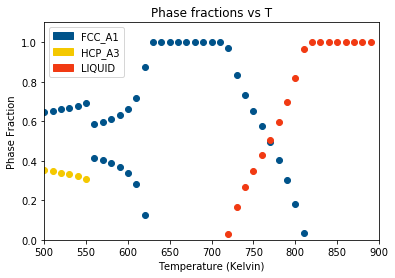

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pycalphad.plot.utils import phase_legend
phases = sorted(set(eq.Phase.values.flatten()) - {''})
phase_handles, phasemap = phase_legend(phases)

plt.gca().set_title('Phase fractions vs T')
plt.gca().set_xlabel('Temperature (Kelvin)')
plt.gca().set_ylabel('Phase Fraction')
plt.gca().set_ylim((0,1.1))
plt.gca().set_xlim((500, 900))

for name in phases:
    plt.scatter(eq.T.broadcast_like(eq.NP), eq.NP.where(eq.Phase == name), color=phasemap[name])
plt.gca().legend(phase_handles, phases, loc='upper left')

### Export to CSV

This code renames the columns and exports to `out.csv`

In [3]:
desired_phases = phases
# Uncomment the following line if you only want to create new columns for *stable* phases
# desired_phases = sorted(set(np.unique(eq.Phase.values)) - {''})

# Create a new data variable (column) for the phase fraction of each phase
for phase_name in desired_phases:
    eq[f'NP({phase_name})'] = eq.where(eq.Phase == phase_name).NP

# Flatten the entire multi-dimensional Pandas Dataframe and write to a CSV
eq.to_dataframe().to_csv('out.csv')

These are the first few rows of the CSV file:

In [4]:
! head out.csv

N,P,T,X_ZN,component,internal_dof,vertex,NP,GM,MU,X,Y,Phase,NP(FCC_A1),NP(HCP_A3),NP(LIQUID)
1.0,101325.0,500.0,0.4,AL,0,0,0.6473966935183969,-18435.074163182573,-15844.548647638076,0.9218335790043238,0.9218335790043238,FCC_A1,0.6473966935183969,,
1.0,101325.0,500.0,0.4,AL,0,1,0.3526033064816031,-18435.074163182573,-15844.548647638076,0.009098011616448487,0.009098011616448487,HCP_A3,,0.3526033064816031,
1.0,101325.0,500.0,0.4,AL,0,2,,-18435.074163182573,-15844.548647638076,,,,,,
1.0,101325.0,500.0,0.4,AL,1,0,0.6473966935183969,-18435.074163182573,-15844.548647638076,0.9218335790043238,0.07816642099567621,FCC_A1,0.6473966935183969,,
1.0,101325.0,500.0,0.4,AL,1,1,0.3526033064816031,-18435.074163182573,-15844.548647638076,0.009098011616448487,0.9909019883835515,HCP_A3,,0.3526033064816031,
1.0,101325.0,500.0,0.4,AL,1,2,,-18435.074163182573,-15844.548647638076,,,,,,
1.0,101325.0,500.0,0.4,ZN,0,0,0.6473966935183969,-18435.074163182573,-22320.86242757112,0.07816642099567621,0.9218335790043238